# Pre-Computed Embeddings with Pinecone in NYC Landmarks Vector Database

This notebook provides a comprehensive guide to working with pre-computed embeddings in the NYC Landmarks Vector Database project, focusing on how Pinecone stores and retrieves these vectors.

## Introduction

Pinecone is a vector database that stores pre-computed embeddings, making it ideal for similarity search applications. In this notebook, we'll explore:

1. How Pinecone stores pre-computed vectors
2. Strategies for working with pre-computed embeddings
3. Optimizing query performance using cached embeddings
4. Best practices for vector management

By the end of this notebook, you'll understand how to effectively leverage pre-computed embeddings for faster and more efficient queries.

## 1. Setup & Imports

Let's start by importing the necessary libraries and setting up our environment.

In [2]:
# Standard libraries
import sys
import time
import json
import pickle
from typing import Dict, List, Any, Optional

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

# Add project directory to path
sys.path.append("..")

# Import project modules
from nyc_landmarks.config.settings import settings
from nyc_landmarks.embeddings.generator import EmbeddingGenerator
from nyc_landmarks.vectordb.pinecone_db import PineconeDB

# Configure logging
import logging
logger = logging.getLogger()
logging.basicConfig(
    level=settings.LOG_LEVEL.value,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

## 2. Understanding Pre-computed Embeddings

### What are Pre-computed Embeddings?

Pre-computed embeddings are vector representations of text (or other data) that have been generated in advance and stored for later use. In the context of our NYC Landmarks project:

- **Text → Vector**: Each piece of text (description of a landmark, historical information, etc.) is converted into a vector (list of floating-point numbers) using an embedding model like OpenAI's text-embedding-ada-002.
- **Storage**: These vectors are stored in a vector database (Pinecone) for efficient similarity search.
- **Retrieval**: When a query is made, we find the most similar vectors to the query's vector.

### Why Use Pre-computed Embeddings?

1. **Performance**: Generating embeddings is computationally expensive and time-consuming. Pre-computing them allows for faster query responses.
2. **Cost Efficiency**: API calls to embedding models (like OpenAI) cost money. Generating embeddings once and reusing them reduces costs.
3. **Consistency**: Ensures consistent vector representations across multiple queries.
4. **Scalability**: Enables handling large datasets with minimal query-time overhead.

Let's see how we generate embeddings in our project:

In [3]:
# Initialize the embedding generator
embedding_generator = EmbeddingGenerator()

# Example text to embed
sample_text = "The Empire State Building is a 102-story Art Deco skyscraper in Midtown Manhattan, New York City."

# Measure the time taken to generate an embedding
start_time = time.time()
embedding = embedding_generator.generate_embedding(sample_text)
end_time = time.time()

print(f"Generated embedding with {len(embedding)} dimensions")
print(f"Time taken: {end_time - start_time:.3f} seconds")

# Show a small portion of the embedding vector
print("\nEmbedding vector (first 10 dimensions):")
print(embedding[:10])

INFO:nyc_landmarks.embeddings.generator:Initialized OpenAI client with model: text-embedding-3-small
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Generated embedding with 1536 dimensions
Time taken: 1.002 seconds

Embedding vector (first 10 dimensions):
[-0.021191075444221497, -0.010425769723951817, 0.02518562413752079, 0.04397997260093689, -0.03714929521083832, 0.03425324708223343, -0.015498844906687737, -0.0025689934846013784, 0.012173384428024292, 0.013281871564686298]


## 3. How Pinecone Stores Vectors

Pinecone is a vector database designed specifically for storing and searching pre-computed vectors. Let's connect to our Pinecone index and explore how it works:

In [4]:
# Initialize the Pinecone database client
pinecone_db = PineconeDB()

# Check if the connection was successful
if pinecone_db.index:
    print(f"✅ Successfully connected to Pinecone index: {pinecone_db.index_name}")
    print(f"Namespace: {pinecone_db.namespace}")
    print(f"Dimensions: {pinecone_db.dimensions}")
else:
    print("❌ Failed to connect to Pinecone. Check your credentials and network connection.")

# Get index statistics
stats = pinecone_db.get_index_stats()

print("\n📊 Index Statistics:")
print(f"Total Vector Count: {stats.get('total_vector_count', 0):,}")
print(f"Dimension: {stats.get('dimension')}")
print(f"Index Fullness: {stats.get('index_fullness')}")

2025-05-23 18:19:09,579 - nyc_landmarks.vectordb.pinecone_db - INFO - Initialized Pinecone client


INFO:nyc_landmarks.vectordb.pinecone_db:Initialized Pinecone client


2025-05-23 18:19:10,006 - nyc_landmarks.vectordb.pinecone_db - INFO - Connected to Pinecone index: nyc-landmarks


INFO:nyc_landmarks.vectordb.pinecone_db:Connected to Pinecone index: nyc-landmarks


✅ Successfully connected to Pinecone index: nyc-landmarks
Namespace: landmarks
Dimensions: 1536

📊 Index Statistics:
Total Vector Count: 35,263
Dimension: 1536
Index Fullness: 0.0


### Pinecone's Vector Storage Architecture

Pinecone stores vectors in a way that optimizes for similarity search. Here's how it works:

1. **Vector Storage**: When you upload vectors to Pinecone, they are stored in their original form (pre-computed).
   - Each vector is associated with a unique ID
   - Metadata can be attached to each vector
   - The dimensionality of all vectors must be consistent

2. **Indexing**: Pinecone builds specialized indexes to enable fast similarity search:
   - Vectors are organized into clusters based on similarity
   - Various indexing algorithms (e.g., HNSW - Hierarchical Navigable Small World) are used to optimize search

3. **Querying**: When you search, Pinecone compares your query vector to stored vectors:
   - Similarity is typically measured using cosine similarity, Euclidean distance, or dot product
   - Results are returned as vectors and their IDs, sorted by similarity score

Let's examine the `query_vectors` method from our PineconeDB class to understand how querying works:

In [ ]:
# The implementation of query_vectors from PineconeDB

'''
def query_vectors(
    self,
    query_vector: List[float],
    top_k: int = 5,
    filter_dict: Optional[Dict[str, Any]] = None,
) -> List[Dict[str, Any]]:
    """
    Query vectors from Pinecone index.

    Args:
        query_vector: Embedding of the query text
        top_k: Number of results to return
        filter_dict: Dictionary of metadata filters

    Returns:
        List of matching vectors with metadata
    """
    try:
        response = self.index.query(
            vector=query_vector,
            top_k=top_k,
            include_metadata=True,
            filter=filter_dict,
        )

        # Process the response to extract matches
        result_list: List[Dict[str, Any]] = []

        # Handle response.matches which can be a list or other iterable
        # Cast response to Any to handle different return types from Pinecone SDK
        from typing import Any as TypeAny
        from typing import cast

        response_dict = cast(TypeAny, response)

        # Access matches safely
        matches = getattr(response_dict, "matches", [])
        for match in matches:
            # Handle match objects
            match_dict: Dict[str, Any] = {}

            # Extract ID if available
            if hasattr(match, "id"):
                match_dict["id"] = match.id

            # Extract score if available
            if hasattr(match, "score"):
                match_dict["score"] = match.score

            # Extract metadata if available
            if hasattr(match, "metadata"):
                match_dict["metadata"] = match.metadata

            result_list.append(match_dict)

        return result_list

    except Exception as e:
        logger.error(f"Failed to query vectors: {e}")
        return []
'''

# Note: This code block is for reference only and won't be executed

## 4. Practical Examples with Pre-computed Embeddings

Now that we understand how pre-computed embeddings work with Pinecone, let's explore practical examples and strategies for leveraging them effectively.

### Example 1: Using Pre-computed Embeddings for Common Queries

In many applications, certain queries are common and repeated frequently. Pre-computing and caching embeddings for these queries can significantly improve performance.

In [5]:
# Define some common queries about NYC landmarks
common_queries = [
    "What is the Empire State Building?",
    "Tell me about the Brooklyn Bridge",
    "What are the historic districts in Manhattan?",
    "What is the architectural style of Grand Central Terminal?",
    "When was the Statue of Liberty designated as a landmark?",
]

# Create an embedding cache
embedding_cache = {}

print("Generating and caching embeddings for common queries...")
for query in common_queries:
    # Measure embedding generation time
    start_time = time.time()
    embedding_cache[query] = embedding_generator.generate_embedding(query)
    end_time = time.time()
    print(f"  - '{query}': {end_time - start_time:.3f}s")

print(f"\nCache contains {len(embedding_cache)} pre-computed embeddings")

Generating and caching embeddings for common queries...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


  - 'What is the Empire State Building?': 0.586s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


  - 'Tell me about the Brooklyn Bridge': 0.229s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


  - 'What are the historic districts in Manhattan?': 0.433s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


  - 'What is the architectural style of Grand Central Terminal?': 0.378s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


  - 'When was the Statue of Liberty designated as a landmark?': 0.218s

Cache contains 5 pre-computed embeddings


In [6]:
# Function to execute a query using a cached embedding if available
def execute_query_with_cache(
    query_text: str,
    embedding_cache: Dict[str, List[float]],
    top_k: int = 5,
    filter_dict: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:
    """Execute a vector search query using cached embeddings when available."""
    # Start timing
    start_time = time.time()

    # Check if query is in cache
    cache_hit = query_text in embedding_cache

    # Get embedding (from cache or generate new)
    embedding_start = time.time()
    if cache_hit:
        query_embedding = embedding_cache[query_text]
        embedding_source = "cache"
    else:
        query_embedding = embedding_generator.generate_embedding(query_text)
        embedding_source = "generated"
    embedding_time = time.time() - embedding_start

    # Execute the query
    query_start = time.time()
    results = pinecone_db.query_vectors(
        query_vector=query_embedding,
        top_k=top_k,
        filter_dict=filter_dict
    )
    query_time = time.time() - query_start

    # Calculate total time
    total_time = time.time() - start_time

    return {
        "query": query_text,
        "embedding": query_embedding,
        "results": results,
        "metrics": {
            "embedding_time": embedding_time,
            "query_time": query_time,
            "total_time": total_time,
            "result_count": len(results),
            "cache_hit": cache_hit,
            "embedding_source": embedding_source
        }
    }

In [7]:
# Test with a cached query
cached_query = "Tell me about the Brooklyn Bridge"
print(f"Testing cached query: '{cached_query}'")
cached_result = execute_query_with_cache(cached_query, embedding_cache)

# Test with a non-cached query
new_query = "What is the history of the Flatiron Building?"
print(f"\nTesting new query: '{new_query}'")
new_result = execute_query_with_cache(new_query, embedding_cache)

# Compare performance
print("\n🔍 Performance Comparison:\n")
print(f"Cached Query:")
print(f"  - Embedding Time: {cached_result['metrics']['embedding_time']:.6f}s (from {cached_result['metrics']['embedding_source']})")
print(f"  - Query Time: {cached_result['metrics']['query_time']:.3f}s")
print(f"  - Total Time: {cached_result['metrics']['total_time']:.3f}s")
print(f"  - Results: {cached_result['metrics']['result_count']}")

print(f"\nNew Query:")
print(f"  - Embedding Time: {new_result['metrics']['embedding_time']:.3f}s (from {new_result['metrics']['embedding_source']})")
print(f"  - Query Time: {new_result['metrics']['query_time']:.3f}s")
print(f"  - Total Time: {new_result['metrics']['total_time']:.3f}s")
print(f"  - Results: {new_result['metrics']['result_count']}")

# Calculate the speedup
if new_result['metrics']['embedding_time'] > 0:
    speedup = new_result['metrics']['embedding_time'] / cached_result['metrics']['embedding_time']
    print(f"\n⚡ Embedding generation speedup with cache: {speedup:.1f}x")

Testing cached query: 'Tell me about the Brooklyn Bridge'

Testing new query: 'What is the history of the Flatiron Building?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔍 Performance Comparison:

Cached Query:
  - Embedding Time: 0.000001s (from cache)
  - Query Time: 0.269s
  - Total Time: 0.269s
  - Results: 5

New Query:
  - Embedding Time: 0.639s (from generated)
  - Query Time: 0.122s
  - Total Time: 0.761s
  - Results: 5

⚡ Embedding generation speedup with cache: 669721.5x


### Visualizing the Results

Let's create a function to display query results in a readable format and visualize the similarity scores:

In [8]:
def display_query_results(query_result, max_results=None, show_metadata=True):
    """Display query results in a readable format.

    Args:
        query_result: The result dictionary returned by execute_query_with_cache
        max_results: Maximum number of results to display (default: all)
        show_metadata: Whether to display metadata fields (default: True)
    """
    results = query_result['results']
    if max_results:
        results = results[:max_results]

    print(f"Query: '{query_result['query']}'\n")
    print(f"🔍 Found {query_result['metrics']['result_count']} results (showing {len(results)})")
    print(f"⏱️ Total query time: {query_result['metrics']['total_time']:.3f} seconds")

    # Show cache information if available
    if 'cache_hit' in query_result['metrics']:
        cache_status = "HIT ✓" if query_result['metrics']['cache_hit'] else "MISS ✗"
        print(f"💾 Cache: {cache_status} ({query_result['metrics']['embedding_source']})")

    print("-" * 80)

    for i, match in enumerate(results):
        print(f"\n📌 Result #{i+1} - Score: {match['score']:.4f}")
        print(f"ID: {match['id']}")

        if show_metadata and 'metadata' in match:
            metadata = match['metadata']
            print("\nMetadata:")

            # Print important fields first
            priority_fields = ['name', 'borough', 'landmark_type', 'designation_date', 'neighborhood']
            for field in priority_fields:
                if field in metadata and metadata[field]:
                    print(f"  {field.capitalize()}: {metadata[field]}")

            # Print content fields if available
            content_fields = ['text_chunk', 'description', 'text']
            for field in content_fields:
                if field in metadata and metadata[field]:
                    content = metadata[field]
                    snippet = content[:250] + "..." if len(content) > 250 else content
                    print(f"\n  Content ({field}): {snippet}")
                    break

        print("-" * 80)

    # Create visualization of similarity scores
    if results:
        scores = [match['score'] for match in results]
        labels = [
            match.get('metadata', {}).get('name', match['id'][:20])
            for match in results
        ]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(labels, scores, color='skyblue')
        plt.xlabel('Similarity Score')
        plt.title(f'Similarity Scores for "{query_result["query"]}"')
        plt.xlim(0, 1.0)

        # Add the values to the end of each bar
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', va='center')

        plt.tight_layout()
        plt.show()

Query: 'Tell me about the Brooklyn Bridge'

🔍 Found 5 results (showing 5)
⏱️ Total query time: 0.269 seconds
💾 Cache: HIT ✓ (cache)
--------------------------------------------------------------------------------

📌 Result #1 - Score: 0.7182
ID: wiki-Brooklyn_Bridge-LP-00098-chunk-1

Metadata:
  Name: Brooklyn Bridge
  Borough: NA
  Designation_date: 1967-08-24T00:00:00
  Neighborhood: Lower East Side

  Content (text):  acted upon. Numerous other proposals were made during the first fifty years of the bridge's life. Trolley tracks were added in the center lanes of both roadways in 1898, allowing trolleys to use the bridge as well. That year, the formerly separate C...
--------------------------------------------------------------------------------

📌 Result #2 - Score: 0.7103
ID: LP-00956-chunk-4

Metadata:
  Name: Fulton Ferry Historic District
  Borough: Brooklyn
  Designation_date: 1977-06-28T00:00:00
  Neighborhood: Brooklyn Heights

  Content (text):  traffic. Ironic
ally, plans 

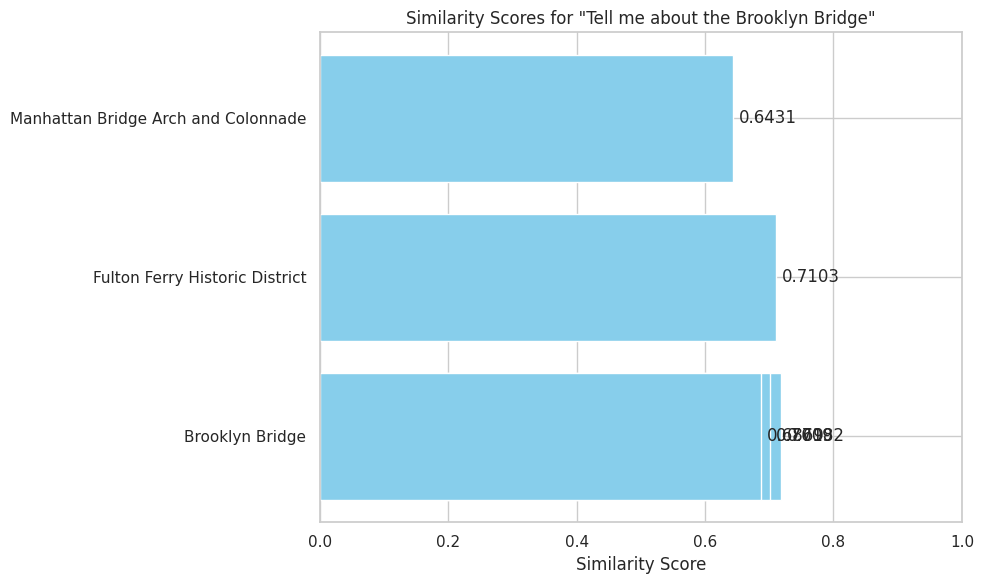

In [9]:
# Test the visualization with our cached query result
display_query_results(cached_result, max_results=5)

## 5. Advanced Techniques with Pre-computed Embeddings

Beyond simple caching, there are several advanced techniques we can use with pre-computed embeddings:

### 5.1 Vector Manipulation

One advantage of working with pre-computed embeddings is that we can manipulate the vectors directly to perform operations like:

- Combining multiple embeddings
- Emphasizing certain aspects of a query
- Creating "negative" queries (find things that are different)

Let's see an example of combining multiple embeddings:

In [10]:
def combine_embeddings(embeddings, weights=None):
    """Combine multiple embeddings into a single embedding.

    Args:
        embeddings: List of embeddings to combine
        weights: Optional weights for each embedding (must sum to 1)

    Returns:
        Combined embedding vector
    """
    if not embeddings:
        raise ValueError("No embeddings provided")

    # Default to equal weights if not specified
    if weights is None:
        weights = [1/len(embeddings)] * len(embeddings)

    # Ensure weights sum to 1
    if abs(sum(weights) - 1.0) > 1e-6:
        weights = [w/sum(weights) for w in weights]

    # Check dimensions match
    dim = len(embeddings[0])
    if not all(len(emb) == dim for emb in embeddings):
        raise ValueError("All embeddings must have the same dimensions")

    # Combine embeddings
    combined = [0.0] * dim
    for i in range(dim):
        for j, embedding in enumerate(embeddings):
            combined[i] += embedding[i] * weights[j]

    # Normalize the combined vector
    magnitude = np.sqrt(sum(x*x for x in combined))
    combined = [x/magnitude for x in combined]

    return combined

# Generate embeddings for two related concepts
print("Generating embeddings for two concepts...")
embedding1 = embedding_generator.generate_embedding("Historic landmark in Brooklyn")
embedding2 = embedding_generator.generate_embedding("Famous bridge in New York")

# Combine the embeddings with different weights
combined_embedding = combine_embeddings([embedding1, embedding2], weights=[0.3, 0.7])

print(f"Embedding 1 dimensions: {len(embedding1)}")
print(f"Embedding 2 dimensions: {len(embedding2)}")
print(f"Combined embedding dimensions: {len(combined_embedding)}")

# Query using the combined embedding
print("\nQuerying with combined embedding...")
results = pinecone_db.query_vectors(query_vector=combined_embedding, top_k=5)
print(f"Found {len(results)} results")

# Show the top result
if results:
    top_result = results[0]
    print(f"\nTop result:")
    print(f"  ID: {top_result['id']}")
    print(f"  Score: {top_result['score']:.4f}")

    if 'metadata' in top_result and 'name' in top_result['metadata']:
        print(f"  Name: {top_result['metadata']['name']}")

Generating embeddings for two concepts...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Embedding 1 dimensions: 1536
Embedding 2 dimensions: 1536
Combined embedding dimensions: 1536

Querying with combined embedding...
Found 5 results

Top result:
  ID: LP-00098-chunk-0
  Score: 0.7032
  Name: Brooklyn Bridge


### 5.2 Persistent Storage of Pre-computed Embeddings

For production applications, you'll want to store your pre-computed embeddings persistently. Here are some options:

1. **Local File Storage**: Save embeddings to disk with pickle or JSON
2. **Database Storage**: Store embeddings in a relational or NoSQL database
3. **Cloud Storage**: Store embeddings in S3, Azure Blob Storage, etc.
4. **Redis**: Use Redis with vector support for fast retrieval

Let's demonstrate how to store and load embeddings using pickle:

In [11]:
def save_embeddings_to_file(embeddings_dict, filepath):
    """Save embeddings dictionary to a file using pickle.

    Args:
        embeddings_dict: Dictionary of embeddings
        filepath: Path to save the file
    """
    with open(filepath, 'wb') as f:
        pickle.dump(embeddings_dict, f)
    print(f"Saved {len(embeddings_dict)} embeddings to {filepath}")

def load_embeddings_from_file(filepath):
    """Load embeddings dictionary from a file.

    Args:
        filepath: Path to the file

    Returns:
        Dictionary of embeddings
    """
    with open(filepath, 'rb') as f:
        embeddings_dict = pickle.load(f)
    print(f"Loaded {len(embeddings_dict)} embeddings from {filepath}")
    return embeddings_dict

# Save our embedding cache to a file
embeddings_file = "../data/cached_embeddings.pkl"

# Create a small metadata structure to save along with embeddings
cache_metadata = {
    "model": settings.OPENAI_EMBEDDING_MODEL,
    "dimensions": settings.OPENAI_EMBEDDING_DIMENSIONS,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "queries": list(embedding_cache.keys())
}

# Create a dictionary with both embeddings and metadata
save_data = {
    "embeddings": embedding_cache,
    "metadata": cache_metadata
}

# Uncomment the following lines to actually save and load the embeddings
# save_embeddings_to_file(save_data, embeddings_file)
# loaded_data = load_embeddings_from_file(embeddings_file)
# loaded_embeddings = loaded_data["embeddings"]
# loaded_metadata = loaded_data["metadata"]
# print(f"Loaded embeddings for {len(loaded_embeddings)} queries")
# print(f"Model used: {loaded_metadata['model']}")
# print(f"Created at: {loaded_metadata['created_at']}")

## 6. How Pinecone Handles Similarity Search

Pinecone uses Approximate Nearest Neighbors (ANN) algorithms to efficiently search through large vector spaces. Let's understand this process:

### 6.1 Approximate Nearest Neighbors (ANN)

Exact nearest neighbor search becomes prohibitively expensive as the number of vectors grows. ANN algorithms trade perfect accuracy for massive performance gains:

1. **Indexing Structures**: Vectors are organized into specialized data structures
2. **Pruning**: Large portions of the vector space can be eliminated from search
3. **Approximation**: Results are very close to the exact nearest neighbors, but found much faster

### 6.2 Pinecone's Search Process

When you query Pinecone with a vector:

1. The query vector is compared to a subset of the stored vectors
2. The most similar vectors are identified
3. Results are returned sorted by similarity score

Importantly, Pinecone only compares your query vector to the pre-computed vectors it stores. It doesn't modify or re-compute these vectors during the search process.

### 6.3 Trade-offs in Vector Search

- **Accuracy vs. Speed**: Higher accuracy requires more comparisons, which takes more time
- **Index Size vs. Query Speed**: More complex indexes are faster for queries but use more memory
- **Batch Size vs. Latency**: Larger batches are more efficient but increase latency

## 7. Vector Similarity Metrics

Pinecone supports several similarity metrics to compare vectors:

1. **Cosine Similarity**: Measures the cosine of the angle between vectors (1.0 is perfect similarity)
2. **Euclidean Distance**: Measures the straight-line distance between vectors (lower is more similar)
3. **Dot Product**: Simple multiplication of vector elements (higher is more similar)

In our NYC Landmarks project, we use cosine similarity as it's generally most effective for text embeddings.

Let's implement a simple function to calculate cosine similarity between two embeddings:

In [12]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors.

    Args:
        vec1: First vector
        vec2: Second vector

    Returns:
        Cosine similarity score (between -1 and 1, higher is more similar)
    """
    # Convert to numpy arrays for efficient computation
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)

    # Calculate dot product
    dot_product = np.dot(vec1, vec2)

    # Calculate magnitudes
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)

    # Calculate cosine similarity
    if magnitude1 * magnitude2 == 0:
        return 0.0  # Handle zero vectors
    else:
        return dot_product / (magnitude1 * magnitude2)

# Calculate similarity between our embeddings
similarity = cosine_similarity(embedding1, embedding2)
print(f"Cosine similarity between 'Historic landmark in Brooklyn' and 'Famous bridge in New York': {similarity:.4f}")

# Calculate similarity with the combined embedding
sim1 = cosine_similarity(combined_embedding, embedding1)
sim2 = cosine_similarity(combined_embedding, embedding2)

print(f"\nSimilarity of combined embedding with:")
print(f"  - 'Historic landmark in Brooklyn': {sim1:.4f}")
print(f"  - 'Famous bridge in New York': {sim2:.4f}")

Cosine similarity between 'Historic landmark in Brooklyn' and 'Famous bridge in New York': 0.5048

Similarity of combined embedding with:
  - 'Historic landmark in Brooklyn': 0.7342
  - 'Famous bridge in New York': 0.9567


## 8. Performance Optimization Strategies

Based on our understanding of pre-computed embeddings, here are strategies to optimize query performance in production:

### 8.1 Client-Side Embedding Cache

Implement a client-side cache for frequently used queries:

```python
# Pseudocode for a simple LRU cache for embeddings
from functools import lru_cache

@lru_cache(maxsize=1000)
def get_embedding(query_text):
    return embedding_generator.generate_embedding(query_text)
```

### 8.2 Query Classification

Classify incoming queries and map them to pre-computed queries when appropriate:

```python
# Pseudocode for query classification
def classify_query(query_text):
    if "empire state building" in query_text.lower():
        return "empire_state_building"
    elif "brooklyn bridge" in query_text.lower():
        return "brooklyn_bridge"
    # ... more classifications
    else:
        return None
```

### 8.3 Batch Processing

For applications that process multiple queries, batch them to reduce overhead:

```python
# Pseudocode for batch embedding generation
def generate_embeddings_batch(texts):
    return embedding_generator.generate_embeddings(texts)  # Assuming this method exists
```

### 8.4 Vector Quantization

For very large embedding caches, consider vector quantization to reduce memory usage:

```python
# Pseudocode for vector quantization
def quantize_vector(vector, bits=8):
    # Implement quantization logic here
    return quantized_vector
```

## 9. Frequently Asked Questions

### 9.1 Does Pinecone store pre-computed vectors?

**Yes**, Pinecone only stores pre-computed vectors. It does not generate embeddings itself.

- **What Pinecone stores**: Pre-computed vector embeddings, IDs, and metadata
- **What Pinecone does not do**: Generate embeddings from raw text

### 9.2 How are vectors stored in Pinecone?

Vectors are stored in their original form (as floating-point arrays) along with:
- A unique ID for each vector
- Optional metadata (key-value pairs)

Pinecone builds specialized indexes on top of these vectors to enable efficient similarity search.

### 9.3 What happens when I query Pinecone?

When you query Pinecone:

1. You provide a query vector (not raw text)
2. Pinecone compares this vector to the stored vectors using the specified similarity metric
3. Pinecone returns the most similar vectors, their IDs, and metadata

### 9.4 Do I need to generate embeddings for every query?

Not necessarily. You can:

1. Cache embeddings for common queries
2. Pre-compute embeddings for expected queries
3. Use vector manipulation to handle variations of queries

### 9.5 How can I optimize my embedding usage?

- **Batch processing**: Generate embeddings in batches
- **Caching**: Store embeddings for common queries
- **Pruning**: Reduce embedding dimensions if needed (though this may affect quality)

## 10. Best Practices for Working with Pre-computed Embeddings

### 10.1 Embedding Generation

- **Consistency**: Use the same model and parameters for all embeddings
- **Preprocessing**: Normalize text inputs (e.g., lowercase, remove extra whitespace)
- **Batch Processing**: Generate embeddings in batches to improve throughput
- **Version Control**: Keep track of the model and parameters used to generate embeddings

### 10.2 Storage and Retrieval

- **Metadata**: Store relevant metadata with each vector for filtering and context
- **ID Strategy**: Use meaningful IDs that can be easily mapped back to source data
- **Compression**: Consider compression techniques for large embedding collections
- **Backup**: Regularly backup your embeddings, especially if generation is expensive

### 10.3 Query Optimization

- **Query Planning**: Analyze common query patterns and pre-compute where possible
- **Caching**: Implement multi-level caching (in-memory, disk, etc.)
- **Monitoring**: Track query performance and cache hit rates
- **Filtering**: Use metadata filters to reduce the search space

### 10.4 Vector Maintenance

- **Updating**: Have a strategy for updating embeddings when models or data change
- **Pruning**: Remove outdated or irrelevant vectors
- **Reindexing**: Plan for periodic reindexing to maintain performance
- **Testing**: Verify search quality periodically with test queries

## 11. Conclusion

In this notebook, we've explored how Pinecone stores and works with pre-computed embeddings in the context of the NYC Landmarks Vector Database project. Key takeaways include:

1. **Pinecone stores pre-computed vectors** - it doesn't generate embeddings itself
2. **Pre-computing embeddings offers significant performance benefits** - especially for common queries
3. **Vector manipulation allows for advanced search strategies** - like combining concepts or emphasizing certain aspects
4. **Proper embedding management is crucial** - including caching, storage, and maintenance

By understanding these concepts, you can build efficient and effective vector search applications with the NYC Landmarks Vector Database.